In [15]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy
from pathlib import Path
from scipy.stats import chi2_contingency 
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from statistics import stdev
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
sns.set_context("notebook")

In [16]:
# File to load
emp_attrition_load = Path("Resources/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Read the data into a Pandas dataframe 
emp_attrition_df = pd.read_csv(emp_attrition_load)

# Check the dataframe
emp_attrition_df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Select categorical columns
cat_cols = []
for i in emp_attrition_df.columns:
    if emp_attrition_df[i].nunique() <= 5 or emp_attrition_df[i].dtype == object:
        cat_cols.append(i)

# Create a new DataFrame with selected columns
df = emp_attrition_df.copy()
df.drop(df[cat_cols], axis=1, inplace=True)
df.drop('EmployeeNumber', axis=1, inplace=True)


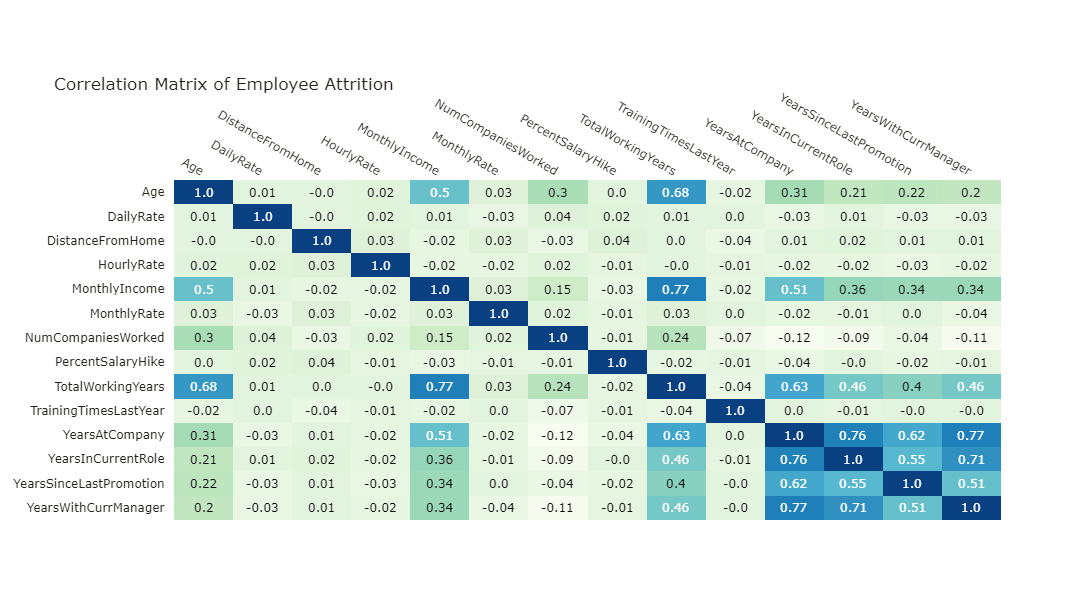

In [7]:
# Calculate correlation matrix
corr = df.corr().round(2)

# Plot the heatmap using plotly
x = corr.index.tolist()
y = corr.columns.tolist()
z = corr.to_numpy()
fig = ff.create_annotated_heatmap(z=z, x=x, y=y, annotation_text=z, name='',
                                  hovertemplate="Correlation between %{x} and %{y}= %{z}",
                                  colorscale='GnBu')
fig.update_yaxes(autorange="reversed")
fig.update_layout(title="Correlation Matrix of Employee Attrition", 
                  font_color='#28221D', margin=dict(t=180), height=600)
fig.show()


MonthlyIncome and TotalWorkingYears have a positive correlation of 0.77. YearsAtCompany is also strongly correlated with YearsWithCurrManager and YearsInCurrentRole (0.77 and 0.76 correlation resp  

DATA CLEANING

In [17]:
# Checking for variables with 0 variance
norm_df=emp_attrition_df.copy()
nzv=[]
for i in norm_df[cat_cols]:
    norm_df[i]=pd.factorize(norm_df[i])[0]
for i in norm_df.columns:
    if stdev(norm_df[i]) == 0.0:
        nzv.append(i)

# Converting cols to category
for i in emp_attrition_df[cat_cols]:
    if i=='Attrition':
        continue
    emp_attrition_df[i] = pd.Categorical(emp_attrition_df[i])

# Removing variables with 0 variance and Employee Number
print("Dropping variables with zero variance:", nzv)
emp_attrition_df.drop(emp_attrition_df[nzv], axis=1, inplace=True)
emp_attrition_df.drop('EmployeeNumber', axis=1, inplace=True)
df=emp_attrition_df.copy()
df.shape

Dropping variables with zero variance: ['EmployeeCount', 'Over18', 'StandardHours']


(1470, 31)

In [18]:
# Check for variables with skew above 0.75
df=emp_attrition_df.copy()
skew_limit = 0.75
skew_vals = df.skew()
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

display(skew_cols.style.set_caption('Columns to be log-transformed:'))

# Log-transform skewed variables
for i in skew_cols.index.values:
    df[i] = df[i].apply(np.log1p)

,Skew
YearsSinceLastPromotion,1.984290
YearsAtCompany,1.764529
MonthlyIncome,1.369817
TotalWorkingYears,1.117172
NumCompaniesWorked,1.026471
DistanceFromHome,0.958118
YearsInCurrentRole,0.917363
YearsWithCurrManager,0.833451
PercentSalaryHike,0.821128


In [12]:
!pip install researchpy


I. Independent T-Test

To compare the average monthly income among current and former employees, an independent t-test was conducted. This will allow us to determine whether there is a statistically significant difference between the average incomes of the two populations. To test this, I'll use the log-transformed data since one of the assumptions of the test is that the continuous variable is approximately normally distributed.

Hypothesis:
H0 : The null hypothesis for the t-test is that the average monthly income of former employees is the same as current employees. u1=u2
 
H1 : The alternative hypothesis is that the average monthly income of former employees is different than current employees. u1≠u2

In [13]:
import researchpy as rp
summary, res=rp.ttest(group1=df['MonthlyIncome'][df['Attrition']=='Yes'], 
                      group2=df['MonthlyIncome'][df['Attrition']=='No'], 
                      group1_name='Former Employees', group2_name='Current Employees')
print("\nSummary Statistics:")
display(summary)
display(res)


Summary Statistics:


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Former Employees,237.0,8.252532,0.640059,0.041576,8.170624,8.334440
1,Current Employees,1233.0,8.610458,0.653497,0.018611,8.573946,8.646970
2,combined,1470.0,8.552752,0.664313,0.017327,8.518764,8.586739


,Independent t-test,results
0,Difference (Former Employees - Current Employe...,-0.3579
1,Degrees of freedom =,1468.0000
2,t =,-7.7477
3,Two side test p value =,0.0000
4,Difference < 0 p value =,0.0000
5,Difference > 0 p value =,1.0000
6,Cohen's d =,-0.5495
7,Hedge's g =,-0.5492
8,Glass's delta1 =,-0.5592
9,Point-Biserial r =,-0.1982


The p-value for the T-Test is 0, indicating statistical significance at a significance level (α) of 0.05. This suggests strong evidence that the average monthly income of former employees differs from that of current employees.

To determine if there is a relationship between Attrition and the other categorical variables in the data set, I will use the chi-square test of independence. The null hypothesis for this test is that the variables are independent, there is no association between Attrition and the variable being tested, while the alternative hypothesis is that that there is a relationship.

In [19]:
# Identifying Categorical Columns:
cat_cols=df.select_dtypes(include="category").columns.tolist() 

# Initializing Lists to Store Chi-Square Statistics and P-values:
chi_statistic=[]
p_val=[]
vars_rm=[]

# Performing Chi-Square Test for Each Categorical Variable:
#appends the results to the chi_statistic and p_val lists. If the p-value is greater than or equal to 0.05, 
#it considers the variables independent and prints a message.
for i in df[cat_cols]:
    observed=pd.crosstab(index=df["Attrition"], columns=df[i])
    stat, p, dof, expected=chi2_contingency(observed)
    chi_statistic.append(stat)
    p_val.append(p)
    if p >= 0.05:
        print("Attrition and {} are independent (p-value = {:.2f}).\n".format(i,p))
        vars_rm.append(i)

# Creating a DataFrame to Store Results
#filters only those rows where the p-value is less than 0.05 and sorts the DataFrame by p-value in ascending order.
chi_df = pd.DataFrame()
chi_df["Variable"] = cat_cols
chi_df["Chi_Statistic"] = chi_statistic
chi_df["P_value"] = p_val
chi_df=chi_df[chi_df.P_value<0.05].sort_values("P_value", ascending=True)
display(chi_df)

Attrition and Education are independent (p-value = 0.55).

Attrition and Gender are independent (p-value = 0.29).

Attrition and PerformanceRating are independent (p-value = 0.99).

Attrition and RelationshipSatisfaction are independent (p-value = 0.15).



,Variable,Chi_Statistic,P_value
11,OverTime,87.564294,8.158424e-21
8,JobRole,86.190254,2.752482e-15
7,JobLevel,72.529013,6.634685e-15
14,StockOptionLevel,60.598301,4.379390e-13
10,MaritalStatus,46.163677,9.455511e-11
6,JobInvolvement,28.492021,2.863181e-06
0,BusinessTravel,24.182414,5.608614e-06
4,EnvironmentSatisfaction,22.503881,5.123469e-05
9,JobSatisfaction,17.505077,5.563005e-04
15,WorkLifeBalance,16.325097,9.725699e-04


In [20]:
# Convert 'Attrition' variable to binary (1 for 'Yes', 0 for 'No')
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# select all columns in the dataframe df except for the 'Attrition' column and assigns it to the feature matrix X.
X=df.loc[:, df.columns != 'Attrition']

# Removing Unwanted Variables from X:
X.drop(X[vars_rm], axis=1, inplace=True)

# one-hot encoding on categorical variables in X
X=pd.get_dummies(X, columns=chi_df.Variable.values, drop_first=True)

# removes spaces from column names in X
X.columns=X.columns.str.replace(' ', '')

# display X
X.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,...,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,Department_Research&Development,Department_Sales,EducationField_LifeSciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_TechnicalDegree
0,41,1102,0.693147,94,8.698514,19479,2.197225,2.484907,2.197225,0,...,0,0,0,0,1,1,0,0,0,0
1,49,279,2.197225,61,8.543056,24907,0.693147,3.178054,2.397895,3,...,0,1,0,1,0,1,0,0,0,0
2,37,1373,1.098612,92,7.645398,2396,1.945910,2.772589,2.079442,3,...,0,1,0,1,0,0,0,0,1,0
3,33,1392,1.386294,56,7.975908,23159,0.693147,2.484907,2.197225,3,...,0,1,0,1,0,1,0,0,0,0
4,27,591,1.098612,40,8.151622,16632,2.302585,2.564949,1.945910,3,...,0,1,0,1,0,0,0,1,0,0


In [22]:
# Training Set (X_train, y_train)
# 70% of the original data (X and y) is used for training,  remaining 30% of the original data is stored in X_rem and y_rem.
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=21)

# Validation and Test Sets (X_val, y_val, X_test, y_test):
# The remaining data (X_rem and y_rem) is further split into validation and test sets.
# 50% of the remaining data is used for validation (X_val and y_val), and the other 50% is used for testing (X_test and y_test).
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=21)

#Displaying Shapes:
print("Train Shape:", X_train.shape, y_train.shape)
print("Validation set Shape:", X_val.shape,y_val.shape)
print("Test set Shape:", X_test.shape, y_test.shape)

Train Shape: (1029, 53) (1029,)
Validation set Shape: (220, 53) (220,)
Test set Shape: (221, 53) (221,)


In [23]:
# Creating a StandardScaler object
scaler = StandardScaler()

# Scaling (standardizing) the features in the training set and updating the DataFrame
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Scaling the features in the validation set and updating the DataFrame
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

# Scaling the features in the test set and updating the DataFrame
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Displaying the head of the scaled training set
X_train.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,...,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,Department_Research&Development,Department_Sales,EducationField_LifeSciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_TechnicalDegree
0,0.039281,-1.431033,-0.023528,1.548533,0.340625,1.223427,0.781625,-0.229651,-0.269199,1.731250,...,-0.542531,-1.261721,2.950855,-1.374936,1.515941,-0.822129,-0.349482,1.448930,-0.23763,-0.322610
1,-1.056109,1.632008,-1.477589,0.767530,-0.455105,0.525874,-0.582044,-1.269425,-0.677718,-0.607642,...,-0.542531,0.792568,-0.338885,0.727306,-0.659656,-0.822129,-0.349482,1.448930,-0.23763,-0.322610
2,0.039281,1.493788,-0.202448,0.865156,-0.584167,1.596613,-1.613621,-0.229651,-0.269199,-0.607642,...,-0.542531,-1.261721,-0.338885,0.727306,-0.659656,-0.822129,-0.349482,-0.690165,-0.23763,3.099717
3,-0.179797,1.449361,0.390459,-0.892100,-0.022621,0.641145,-0.582044,1.110851,0.183017,1.731250,...,-0.542531,0.792568,-0.338885,0.727306,-0.659656,-0.822129,-0.349482,1.448930,-0.23763,-0.322610
4,2.339599,-0.500520,1.305609,0.279404,1.850835,-0.337603,0.781625,-0.551134,1.607744,-0.607642,...,1.843213,-1.261721,-0.338885,-1.374936,1.515941,1.216354,-0.349482,-0.690165,-0.23763,-0.322610


In [26]:
# performing hyperparameter tuning for a Random Forest classifier 
# Define the parameter grid for RandomizedSearchCV
grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
        'max_features': [None, 'sqrt'],
        'max_depth': [None, 5, 7, 14, 21],
        'min_samples_split': [2, 5, 8],
        'min_samples_leaf': [3, 4, 5],
        'bootstrap': [True, False]}

# Create a Random Forest classifier
rf=RandomForestClassifier(random_state=92)

## Initialize RandomizedSearchCV
rf_cv=RandomizedSearchCV(estimator=rf, # The base model
                         param_distributions=grid, # The parameter grid for random search
                         scoring='roc_auc', # The scoring metric
                         n_iter=100, # Number of iterations for random search
                         cv=5, # Number of cross-validation folds
                         random_state=92, # Random seed for reproducibility
                         n_jobs=-1)  # Use all available CPU cores

# Fit RandomizedSearchCV to the training data
rf_cv.fit(X_train, y_train)

print("Grid Search CV Best AUC = {:.3f}\nBest Params: {}".format(rf_cv.best_score_, rf_cv.best_estimator_))

Grid Search CV Best AUC = 0.777
Best Params: RandomForestClassifier(bootstrap=False, max_depth=7, min_samples_leaf=4,
                       min_samples_split=5, random_state=92)


Using cross-validation to tune the parameters, the random forest model with the best Area Under the Curve grows to a maximum depth of no more than 7 splits in each tree. The subset of features considered when looking for the best split is the squareroot of the total number of features. In addition, at least 5 samples are required to split an internal node with a minimum of 4 samples in each leaf node.

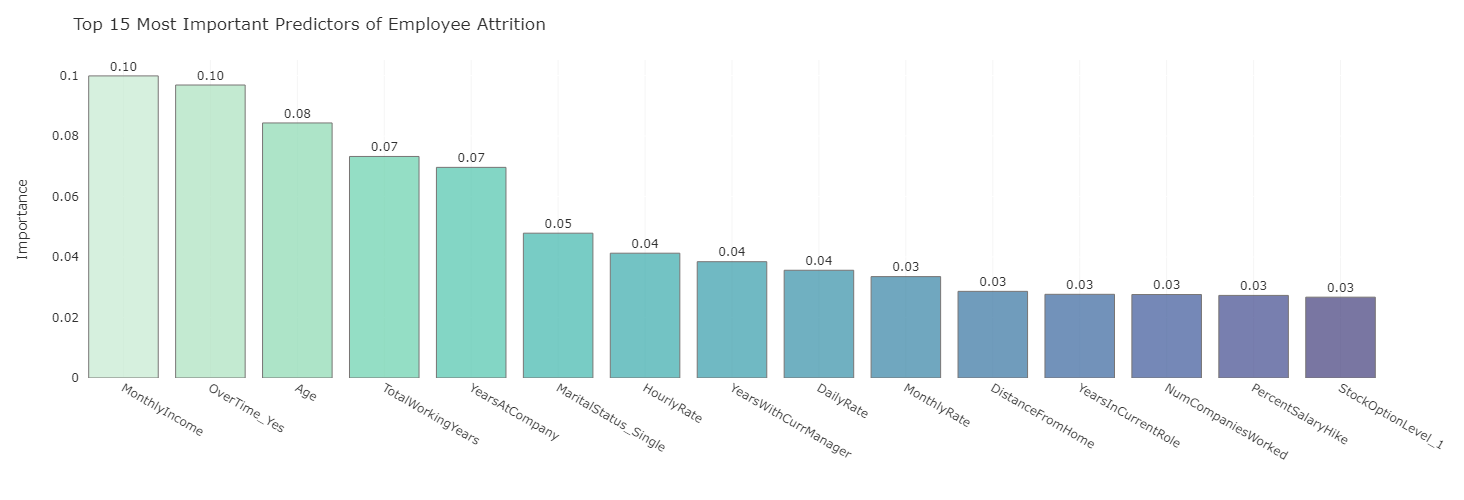

In [28]:
# visualize the top 15 most important predictors of employee attrition as determined by a Random Forest classifier
col=sns.color_palette("mako", 20).as_hex()[::-1]
feat=pd.DataFrame({"Importance": rf_cv.best_estimator_.feature_importances_}, index=X_train.columns
                 ).sort_values(by="Importance")
plot_df=feat.nlargest(15, columns='Importance').sort_values(by="Importance", ascending=False)
fig = px.bar(plot_df, x=plot_df.index, y='Importance', text='Importance', 
             color=plot_df.index, opacity=0.7, color_discrete_sequence=col)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside',
                  marker_line=dict(width=1, color='#3F3B3A'), 
                  hovertemplate='%{x}<br>Importance = %{y:.2f}')
fig.update_layout(title_text='Top 15 Most Important Predictors of Employee Attrition', 
                  coloraxis_showscale=False, showlegend=False,font_color="#303030", height = 500,
                  paper_bgcolor='white', plot_bgcolor='white', yaxis_title="Importance", 
                  xaxis = dict(title="", showgrid=True, gridcolor="#f5f5f5"))
fig.show()

This bar chart illustrates the key factors influencing the prediction of employee attrition through the Gini importance measure in a random forest model. The importance of a variable is determined by the reduction in impurity at tree nodes resulting from splitting on that particular feature, averaged across all trees within the model. According to the chart, monthly income, age, and overtime work emerge as the most significant predictors of employee attrition. Additionally, factors pertaining to employment history, such as total years of service, duration with the company and current manager, along with proximity to the workplace and salary increments, are identified as crucial contributors to the prediction of employee attrition.This bar graph shows the most important variables in predicting employee attrition using random forest's Gini importance measure. Variable importance is calculated by the decrease in the tree node's impurity from splitting on that feature, averaged over all of the trees in the model. Based on this graph, monthly income, age, and working overtime are the most important predictors of employee attrition. In addition, information related to their job history, like the total number of years they've worked and the length of time they've been with the company and with their current manager, as well as their proximity to the office and salary rate increases are some of the most important contributors in predicting employee attrition.

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Assuming rmfr is your RandomForestClassifier and X_test, y_test are your test data
predrmfr = rmfr.predict(X_test)

# Print confusion matrix, accuracy score, and classification report
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test, predrmfr))
print("Score:", round(accuracy_score(y_test, predrmfr) * 100, 2))
print("Classification Report:")
print(classification_report(y_test, predrmfr))


Confusion Matrix for Random Forest Classifier:
[[183   2]
 [ 30   6]]
Score: 85.52
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       185
           1       0.75      0.17      0.27        36

    accuracy                           0.86       221
   macro avg       0.80      0.58      0.60       221
weighted avg       0.84      0.86      0.81       221

